In [1]:
import time
import cv2
import math

import numpy as np

from swarm import Swarm


In [2]:
NUM_DRONES = 5

AREA_SIZE_X = 100
AREA_SIZE_Y = 100
GRID_SIZE = 100           # Size of the Forest

CAMERA_FOV_DEGREE = 50
IMAGE_SIZE = 512 #How many Scanning points each image has per Row (Images are 512x512)

MOVE_DISTANCE = 1       # How far a Drone can move each Timestep
DRONE_HEIGHT = 35

POPULATION_SIZE = 10
NUM_GENERATIONS = 2
MUTATION_RATE = 0.1

INITIAL_VISIBILITY =0.5

In [3]:
grid_offset=GRID_SIZE/2

camera_fov=np.deg2rad(CAMERA_FOV_DEGREE)
camera_offset= 35 * np.tan(camera_fov/2)

prob_array_size= int(np.ceil((GRID_SIZE*512)/(camera_offset*2)))

In [4]:
ShouldPrint=False

In [5]:
#Create "Base Grid"
#by Calculating distance between each scanning point at DRONE_HEIGHT

#Gives Coordinates based on drone position and scan pixel
def calculate_world_coordinates(drone_pos, image_radius, img_x, img_y):
    pos_x = drone_pos[0] + (img_x-256)/512 * image_radius * 2
    pos_y = drone_pos[1] + (img_y-256)/512 * image_radius * 2
    return (pos_x, pos_y)


    return array_width,array_height
def getOverlapArray(waypoints,img_width=512,img_height=512):
    #TODO change MinX to value instead of array,its probably not needed 
    MinX = [0,float('inf')]
    MaxX = [0,float('-inf')]
    MinY = [0,float('inf')]
    MaxY = [0,float('-inf')]
    
    for i in range(len(waypoints)):
        x = waypoints[i][0]
        y = waypoints[i][1]
        #Determine the Minimum X,Y and Maximum X,Y of the sampling positions and saves which drone
        if (x < MinX[1]):
            MinX = [i, x]
        if (x > MaxX[1]):
            MaxX = [i, x]
        if (y < MinY[1]):
            MinY = [i, y]
        if (y > MaxY[1]):
            MaxY = [i, y]
    
    MinX[1] = calculate_world_coordinates(waypoints[MinX[0]], camera_offset, 0,0)[0]
    MaxX[1] = calculate_world_coordinates(waypoints[MaxX[0]], camera_offset, img_width,img_height)[0]
    MinY[1] = calculate_world_coordinates(waypoints[MinY[0]], camera_offset, 0,0)[1]
    MaxY[1] = calculate_world_coordinates(waypoints[MaxY[0]], camera_offset, img_width, img_height)[1]  
    
    #gets the needed width/height of the array based on the distance between smallest and largest X/Y Value, rounding up
    array_width = int(np.ceil(((MaxX[1]-MinX[1])*img_width)/(camera_offset*2)))
    array_height = int(np.ceil(((MaxY[1]-MinY[1])*img_height)/(camera_offset*2)))

    #fills the array with zeroes
    visibility_array = np.zeros((int(array_width), (int(array_height))))
    
    visibility_threshold= 3400 #once depth is higher than this value, the ground counts as seen
    
    #adds 1/NUM_DRONES if the point is seen
    for id in range(len(waypoints)):
        for i in range(img_width):
            for j in range(img_height):
                if swarm.depth_images[id][i][j][0] > visibility_threshold:
                    world_x, world_y = calculate_world_coordinates(waypoints[id], camera_offset, j, i)
                    world_x_idx = int(((world_x - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
                    world_y_idx = int(((world_y - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
                    if 0 <= world_x_idx < array_width and 0 <= world_y_idx < array_height:
                        visibility_array[world_x_idx][world_y_idx] += 1/NUM_DRONES
    
    
    #gets the corner of the visibility array, so correct overlap with probability array can be calculated

    visibility_offset_x=int(((MinX[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    visibility_offset_y=int(((MinY[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    
    visibility_offset=[visibility_offset_x,visibility_offset_y]
    return visibility_array, visibility_offset
    


In [6]:
def getProbabilityGrid(Last_Known_Position, sigma):
    #Create Target Probability Grid
    x = np.linspace(-grid_offset, grid_offset, prob_array_size)
    y = np.linspace(-grid_offset, grid_offset, prob_array_size)
    x, y = np.meshgrid(x, y)

    prob_density = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-((x - Last_Known_Position[0])**2 + (y - Last_Known_Position[1])**2) / (2 * sigma**2))

    return prob_density,x,y

In [7]:
#return percentage of ground visible (depth>34meter)
def check_ground_visibility(depth_image):
    number_visible_ground=0
    for i in depth_image:
        for j in i:
            if j[0]>3400:
                number_visible_ground= number_visible_ground+1
    return number_visible_ground/(512**2)
 
def update_Target_Position():
    if Target_Position[0]<25:
        Target_Position = Target_Position + [0.5,0.5]

Initialization of Drones and Solution Populations

In [9]:
#Spawn Drones and move to initial position

# Create the swarm object by passing the name
# of the world from the .sdf world file.
swarm = Swarm("rhea_swarm")

# Spawn X drones and keep the returning ids as handles
ids = swarm.spawn(NUM_DRONES)

#Initialize Target Position
Target_Position =np.array([5,5])
Last_Known_Position = Target_Position

# First waypoints
waypoints = np.empty((0,3),float)
for i in range (NUM_DRONES):
    waypoints= np.append(waypoints,np.array([[math.ceil(i-(NUM_DRONES/2)),0.0,DRONE_HEIGHT]]), axis=0)

#create Initial
swarm.waypoints(ids, waypoints)

#Visibility by Coordiantes File:
grid_visibility = np.full((AREA_SIZE_X,AREA_SIZE_Y), INITIAL_VISIBILITY)

#Create Target Probability Grid
sigma= 10

prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)

#print(prob_density)


Subscribed successfully


In [10]:
#print(swarm.depth_images[1])
#print(check_ground_visibility(swarm.depth_images[1]))


In [11]:
# Problem classes
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.optimize import minimize

# Algorithmss
from pymoo.algorithms.soo.nonconvex.de import DE

# Survival operators
from pymoo.operators.sampling.lhs import LHS

In [12]:
def scoreThatThing(prob_density,visibility_grid,visibility_offset):
        
    #scoring_array=np.array(prob_density)
    if ShouldPrint:
        print(f"Prob_density {prob_density},\n\n visibility_grid: {visibility_grid},\n\n offset: {visibility_offset}")
        print(f"Prob_size: {np.shape(prob_density)}")
    scoring_array=np.zeros(prob_density.shape)
    score=0
    
    #print("Visibility grid in scoring: ", visibility_grid.shape)
    
    for i in range(visibility_grid.shape[0]):
        for j in range(visibility_grid.shape[1]):
            #
            #scoring_array[i+visibility_offset[0]][j+visibility_offset[1]]*=visibility_grid[i][j]
            scoring_array[i+visibility_offset[0]][j+visibility_offset[1]]=prob_density[i+visibility_offset[0]][j+visibility_offset[1]]*visibility_grid[i][j]
            #only add score if half the drones see square
            if visibility_grid[i][j]>=0.5:
                score+=scoring_array[i+visibility_offset[0]][j+visibility_offset[1]]
                
    #plt.imshow(scoring_array, cmap='gray')
    #plt.show()
    return score

In [13]:
class MyProblem(ElementwiseProblem):

    def __init__(self, grid_size, n_drones, n_steps,waypoints,prob_density):
        
        self.grid_size = grid_size
        self.n_drones = n_drones
        n_var=2*n_drones
        self.n_steps = n_steps
        
        self.waypoints = waypoints
        self.prob_density = prob_density
        
        super().__init__(
            n_var=n_var,  # Variables in the solutions (x,y)
            n_obj=1,      # Number of Objectives we wanna optimize
            n_constr=0,   # No additional constraints, TODO: add no crashing into eachother
            xl=0,      # Lower boundaries of solution variables
            xu=1,       # Upper bounds of solution vars
        )    

        #x are the waypoints
    def _evaluate(self, x, out, *args, **kwargs):
        
        #scales the variables to  [-2,2]
        _x= np.array(x)*4-2
        #reshapes the variables back into a waypoint array
        coordinates = _x.reshape(-1, 2)        
        
        #send drones to solution it wants to score
        tempWaypoints = waypoints + np.pad(coordinates,((0, 0), (0, 1)),mode='constant',constant_values=0)
        swarm.waypoints(ids,tempWaypoints)
        
        isScored = False
        score = None
        
        while not isScored:
            #wait until all drones received
            if swarm.received_frames[ids[-1]]:
                if ShouldPrint:
                    print("All Frames received")
                visibility_grid,visibility_offset = getOverlapArray(tempWaypoints)
                score = scoreThatThing(self.prob_density,visibility_grid,visibility_offset)
                isScored=True
        
        if ShouldPrint:
            print("Score is:", -score, " for solution \n",tempWaypoints)
            
        out["F"] = -score

In [14]:
from pymoo.core.sampling import Sampling
class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = [np.random.rand(problem.n_var)]
        #X = np.array(0)
        for i in range(n_samples-1):
            X= np.append(X,[np.random.rand(problem.n_var)], axis=0)
            #print(f"Sampled X: {X.shape} -> {X}") 
        #print(X)
        return X
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", NUM_GENERATIONS)

In [17]:
problem = MyProblem(GRID_SIZE, NUM_DRONES, NUM_GENERATIONS, waypoints, prob_density)

algorithm = DE(
    pop_size=POPULATION_SIZE,
    sampling=MySampling(),    #Für initiale Population
    variant="DE/rand/1/bin",
    CR=0.9,
    F=0.8,
    dither="vector"
)

In [18]:
import matplotlib.pyplot as plt


Starting Run number 0
Swarm is currently at [[-2.  0. 35.]
 [-1.  0. 35.]
 [ 0.  0. 35.]
 [ 1.  0. 35.]
 [ 2.  0. 35.]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.446678E+03 | -2.562270E+03
     2 |       20 | -2.492090E+03 | -2.578081E+03
Best Solution: 
 [[ 1.98519436  1.96213802]
 [ 0.15075149  1.91382308]
 [-0.03370736  1.79496986]
 [ 1.3262864  -1.98875624]
 [ 0.35722215  0.2044479 ]]
Sending swarm to 
 [[-1.48056367e-02  1.96213802e+00  3.50000000e+01]
 [-8.49248512e-01  1.91382308e+00  3.50000000e+01]
 [-3.37073629e-02  1.79496986e+00  3.50000000e+01]
 [ 2.32628640e+00 -1.98875624e+00  3.50000000e+01]
 [ 2.35722215e+00  2.04447896e-01  3.50000000e+01]]


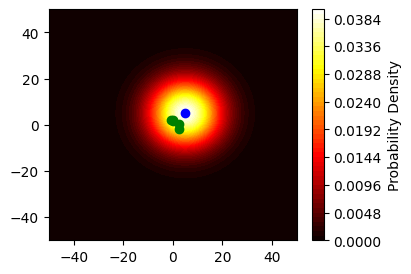

Starting Run number 1
Swarm is currently at [[-1.48056367e-02  1.96213802e+00  3.50000000e+01]
 [-8.49248512e-01  1.91382308e+00  3.50000000e+01]
 [-3.37073629e-02  1.79496986e+00  3.50000000e+01]
 [ 2.32628640e+00 -1.98875624e+00  3.50000000e+01]
 [ 2.35722215e+00  2.04447896e-01  3.50000000e+01]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.513199E+03 | -2.654160E+03
     2 |       20 | -2.546609E+03 | -2.654160E+03
Best Solution: 
 [[-1.60661266 -0.3155695 ]
 [ 1.83155812  0.13266114]
 [ 0.76750846 -0.73793748]
 [ 0.74600371  1.33850269]
 [-1.92684689  1.00057726]]
Sending swarm to 
 [[-1.6214183   1.64656852 35.        ]
 [ 0.98230961  2.04648422 35.        ]
 [ 0.73380109  1.05703239 35.        ]
 [ 3.07229011 -0.65025355 35.        ]
 [ 0.43037526  1.20502516 35.        ]]


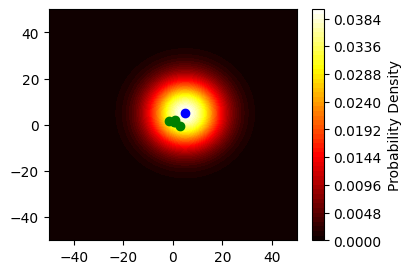

Starting Run number 2
Swarm is currently at [[-1.6214183   1.64656852 35.        ]
 [ 0.98230961  2.04648422 35.        ]
 [ 0.73380109  1.05703239 35.        ]
 [ 3.07229011 -0.65025355 35.        ]
 [ 0.43037526  1.20502516 35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.565219E+03 | -2.752517E+03
     2 |       20 | -2.606729E+03 | -2.752517E+03
Best Solution: 
 [[ 1.53322436  0.49468883]
 [ 1.00376974 -0.60440663]
 [-0.92028843  1.58354487]
 [-0.28763524  1.85936019]
 [ 0.65376599  0.48678288]]
Sending swarm to 
 [[-0.08819394  2.14125735 35.        ]
 [ 1.98607934  1.44207759 35.        ]
 [-0.18648734  2.64057726 35.        ]
 [ 2.78465487  1.20910664 35.        ]
 [ 1.08414125  1.69180804 35.        ]]


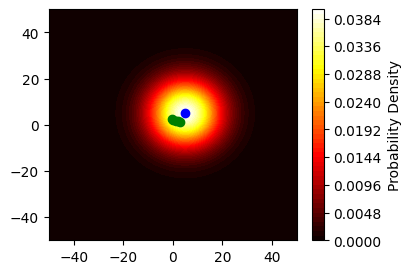

Starting Run number 3
Swarm is currently at [[-0.08819394  2.14125735 35.        ]
 [ 1.98607934  1.44207759 35.        ]
 [-0.18648734  2.64057726 35.        ]
 [ 2.78465487  1.20910664 35.        ]
 [ 1.08414125  1.69180804 35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.632904E+03 | -2.708084E+03
     2 |       20 | -2.657414E+03 | -2.708084E+03
Best Solution: 
 [[ 1.53322436  0.49468883]
 [ 1.00376974 -0.60440663]
 [-0.92028843  1.58354487]
 [-0.28763524  1.85936019]
 [ 0.65376599  0.48678288]]
Sending swarm to 
 [[ 1.44503043  2.63594617 35.        ]
 [ 2.98984908  0.83767096 35.        ]
 [-1.10677577  4.22412213 35.        ]
 [ 2.49701963  3.06846682 35.        ]
 [ 1.73790724  2.17859092 35.        ]]


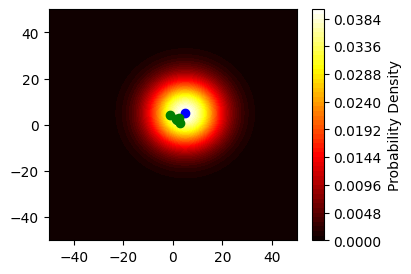

Starting Run number 4
Swarm is currently at [[ 1.44503043  2.63594617 35.        ]
 [ 2.98984908  0.83767096 35.        ]
 [-1.10677577  4.22412213 35.        ]
 [ 2.49701963  3.06846682 35.        ]
 [ 1.73790724  2.17859092 35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.569902E+03 | -2.684329E+03
     2 |       20 | -2.603706E+03 | -2.689396E+03
Best Solution: 
 [[-1.47670947  0.24212503]
 [-1.80654835  0.76929046]
 [ 1.50555661 -1.78600319]
 [ 1.67271598 -1.67991945]
 [-1.32067832  1.51257001]]
Sending swarm to 
 [[-3.16790429e-02  2.87807120e+00  3.50000000e+01]
 [ 1.18330073e+00  1.60696142e+00  3.50000000e+01]
 [ 3.98780836e-01  2.43811895e+00  3.50000000e+01]
 [ 4.16973561e+00  1.38854737e+00  3.50000000e+01]
 [ 4.17228918e-01  3.69116093e+00  3.50000000e+01]]


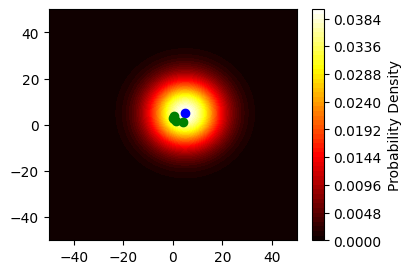

Starting Run number 5
Swarm is currently at [[-3.16790429e-02  2.87807120e+00  3.50000000e+01]
 [ 1.18330073e+00  1.60696142e+00  3.50000000e+01]
 [ 3.98780836e-01  2.43811895e+00  3.50000000e+01]
 [ 4.16973561e+00  1.38854737e+00  3.50000000e+01]
 [ 4.17228918e-01  3.69116093e+00  3.50000000e+01]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.508596E+03 | -2.611175E+03
     2 |       20 | -2.551991E+03 | -2.611175E+03
Best Solution: 
 [[-0.32322194  0.740878  ]
 [-1.182191    1.51246975]
 [-1.89044963  0.68187004]
 [-0.33078079  0.23475931]
 [-1.43845225 -1.20759404]]
Sending swarm to 
 [[-3.54900985e-01  3.61894920e+00  3.50000000e+01]
 [ 1.10973143e-03  3.11943116e+00  3.50000000e+01]
 [-1.49166879e+00  3.11998899e+00  3.50000000e+01]
 [ 3.83895482e+00  1.62330669e+00  3.50000000e+01]
 [-1.02122333e+00  2.48356689e+00  3.50000000e+01]]


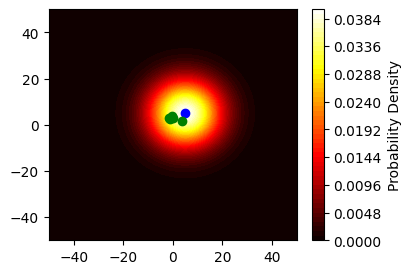

Starting Run number 6
Swarm is currently at [[-3.54900985e-01  3.61894920e+00  3.50000000e+01]
 [ 1.10973143e-03  3.11943116e+00  3.50000000e+01]
 [-1.49166879e+00  3.11998899e+00  3.50000000e+01]
 [ 3.83895482e+00  1.62330669e+00  3.50000000e+01]
 [-1.02122333e+00  2.48356689e+00  3.50000000e+01]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.401561E+03 | -2.485098E+03
     2 |       20 | -2.442571E+03 | -2.547997E+03
Best Solution: 
 [[-0.37162892 -0.83208849]
 [-1.21718082 -1.31614281]
 [-1.66651164 -0.67426346]
 [-1.84853824 -0.80588629]
 [ 1.00324841  0.05737934]]
Sending swarm to 
 [[-7.26529908e-01  2.78686071e+00  3.50000000e+01]
 [-1.21607109e+00  1.80328835e+00  3.50000000e+01]
 [-3.15818043e+00  2.44572553e+00  3.50000000e+01]
 [ 1.99041658e+00  8.17420395e-01  3.50000000e+01]
 [-1.79749153e-02  2.54094623e+00  3.50000000e+01]]


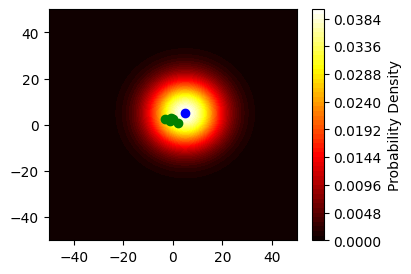

Starting Run number 7
Swarm is currently at [[-7.26529908e-01  2.78686071e+00  3.50000000e+01]
 [-1.21607109e+00  1.80328835e+00  3.50000000e+01]
 [-3.15818043e+00  2.44572553e+00  3.50000000e+01]
 [ 1.99041658e+00  8.17420395e-01  3.50000000e+01]
 [-1.79749153e-02  2.54094623e+00  3.50000000e+01]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.355250E+03 | -2.471605E+03
     2 |       20 | -2.397795E+03 | -2.524609E+03
Best Solution: 
 [[-1.5941901  -0.3155695 ]
 [-0.20400523  0.09444338]
 [ 1.75585883  0.90365371]
 [-1.6765143   1.33850269]
 [-1.92684689  1.69781499]]
Sending swarm to 
 [[-2.32072     2.47129121 35.        ]
 [-1.42007633  1.89773173 35.        ]
 [-1.40232161  3.34937923 35.        ]
 [ 0.31390228  2.15592308 35.        ]
 [-1.94482181  4.23876122 35.        ]]


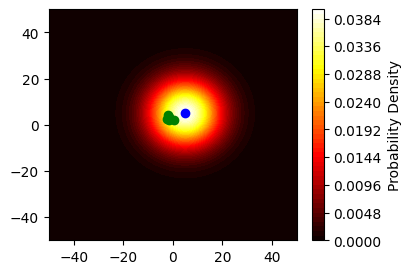

Starting Run number 8
Swarm is currently at [[-2.32072     2.47129121 35.        ]
 [-1.42007633  1.89773173 35.        ]
 [-1.40232161  3.34937923 35.        ]
 [ 0.31390228  2.15592308 35.        ]
 [-1.94482181  4.23876122 35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.330407E+03 | -2.393010E+03
     2 |       20 | -2.358246E+03 | -2.423792E+03
Best Solution: 
 [[ 1.53322436 -0.34377605]
 [ 1.00376974 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[-0.78749564  2.12751516 35.        ]
 [-0.41630659  1.55444881 35.        ]
 [-3.20250777  3.49296486 35.        ]
 [ 0.96908086  2.21547953 35.        ]
 [-0.16644278  4.58498138 35.        ]]


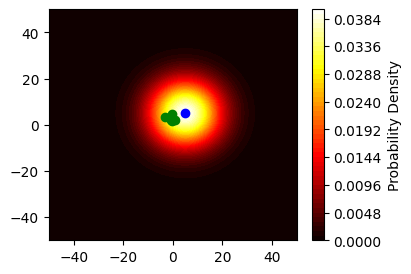

Starting Run number 9
Swarm is currently at [[-0.78749564  2.12751516 35.        ]
 [-0.41630659  1.55444881 35.        ]
 [-3.20250777  3.49296486 35.        ]
 [ 0.96908086  2.21547953 35.        ]
 [-0.16644278  4.58498138 35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.258491E+03 | -2.351815E+03
     2 |       20 | -2.290444E+03 | -2.351815E+03
Best Solution: 
 [[-0.32322194  0.740878  ]
 [-1.182191    1.51246975]
 [-1.89044963  0.68187004]
 [-0.33078079  0.23475931]
 [-1.43845225 -1.20759404]]
Sending swarm to 
 [[-1.11071758  2.86839316 35.        ]
 [-1.59849759  3.06691855 35.        ]
 [-5.0929574   4.1748349  35.        ]
 [ 0.63830007  2.45023884 35.        ]
 [-1.60489503  3.37738734 35.        ]]


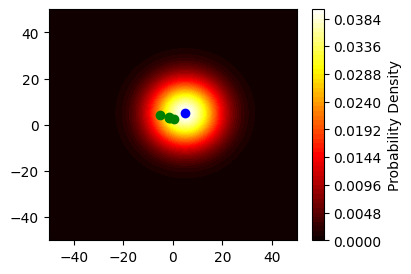

Starting Run number 10
Swarm is currently at [[-1.11071758  2.86839316 35.        ]
 [-1.59849759  3.06691855 35.        ]
 [-5.0929574   4.1748349  35.        ]
 [ 0.63830007  2.45023884 35.        ]
 [-1.60489503  3.37738734 35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.125252E+03 | -2.188038E+03
     2 |       20 | -2.169264E+03 | -2.246629E+03
Best Solution: 
 [[ 1.53322436 -0.34377605]
 [ 1.00376974 -0.34328292]
 [-1.80018616  0.14358562]
 [ 0.65517858  0.05955645]
 [ 1.77837902  0.34622016]]
Sending swarm to 
 [[ 0.42250678  2.52461711 35.        ]
 [-0.59472786  2.72363563 35.        ]
 [-6.89314356  4.31842052 35.        ]
 [ 1.29347865  2.50979529 35.        ]
 [ 0.173484    3.7236075  35.        ]]


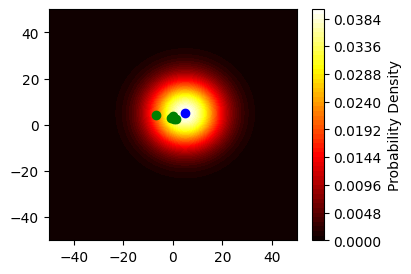

Starting Run number 11
Swarm is currently at [[ 0.42250678  2.52461711 35.        ]
 [-0.59472786  2.72363563 35.        ]
 [-6.89314356  4.31842052 35.        ]
 [ 1.29347865  2.50979529 35.        ]
 [ 0.173484    3.7236075  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.056897E+03 | -2.130858E+03
     2 |       20 | -2.099652E+03 | -2.141615E+03
Best Solution: 
 [[-0.37162892 -0.83208849]
 [-1.21718082 -1.31614281]
 [-1.66651164 -0.67426346]
 [-1.84853824 -0.80588629]
 [ 1.00324841  0.05737934]]
Sending swarm to 
 [[ 0.05087786  1.69252862 35.        ]
 [-1.81190868  1.40749282 35.        ]
 [-8.5596552   3.64415706 35.        ]
 [-0.55505958  1.703909   35.        ]
 [ 1.17673241  3.78098684 35.        ]]


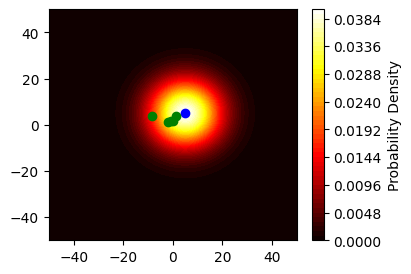

Starting Run number 12
Swarm is currently at [[ 0.05087786  1.69252862 35.        ]
 [-1.81190868  1.40749282 35.        ]
 [-8.5596552   3.64415706 35.        ]
 [-0.55505958  1.703909   35.        ]
 [ 1.17673241  3.78098684 35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.996478E+03 | -2.099812E+03
     2 |       20 | -2.018320E+03 | -2.099812E+03
Best Solution: 
 [[-0.32322194  0.740878  ]
 [-1.182191    1.51246975]
 [-1.89044963  0.68187004]
 [-0.33078079  0.23475931]
 [-1.43845225 -1.20759404]]
Sending swarm to 
 [[ -0.27234408   2.43340662  35.        ]
 [ -2.99409968   2.91996256  35.        ]
 [-10.45010483   4.3260271   35.        ]
 [ -0.88584037   1.93866832  35.        ]
 [ -0.26171984   2.5733928   35.        ]]


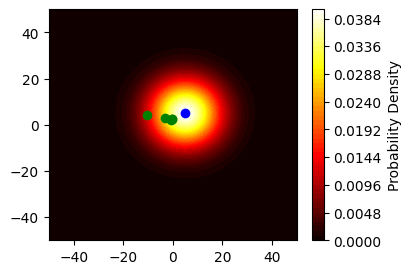

Starting Run number 13
Swarm is currently at [[ -0.27234408   2.43340662  35.        ]
 [ -2.99409968   2.91996256  35.        ]
 [-10.45010483   4.3260271   35.        ]
 [ -0.88584037   1.93866832  35.        ]
 [ -0.26171984   2.5733928   35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.913551E+03 | -2.045079E+03
     2 |       20 | -1.953917E+03 | -2.056453E+03
Best Solution: 
 [[-1.6709193   1.24026251]
 [ 1.90207481 -1.33451629]
 [ 0.35871183  1.59976499]
 [-0.85213194  1.35833438]
 [-1.43845225  0.66681001]]
Sending swarm to 
 [[ -1.94326338   3.67366913  35.        ]
 [ -1.09202487   1.58544627  35.        ]
 [-10.091393     5.9257921   35.        ]
 [ -1.73797231   3.2970027   35.        ]
 [ -1.70017208   3.24020281  35.        ]]


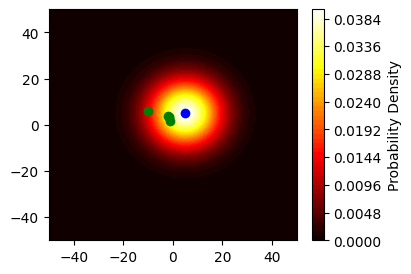

Starting Run number 14
Swarm is currently at [[ -1.94326338   3.67366913  35.        ]
 [ -1.09202487   1.58544627  35.        ]
 [-10.091393     5.9257921   35.        ]
 [ -1.73797231   3.2970027   35.        ]
 [ -1.70017208   3.24020281  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.838273E+03 | -1.953377E+03
     2 |       20 | -1.880451E+03 | -1.953377E+03
Best Solution: 
 [[ 1.61360766 -1.45010118]
 [-1.44289461  1.22956515]
 [-0.40929265 -1.33858321]
 [ 1.71003432 -0.60893656]
 [ 1.00324841  0.90399194]]
Sending swarm to 
 [[-3.29655722e-01  2.22356795e+00  3.50000000e+01]
 [-2.53491948e+00  2.81501143e+00  3.50000000e+01]
 [-1.05006857e+01  4.58720888e+00  3.50000000e+01]
 [-2.79379914e-02  2.68806614e+00  3.50000000e+01]
 [-6.96923670e-01  4.14419475e+00  3.50000000e+01]]


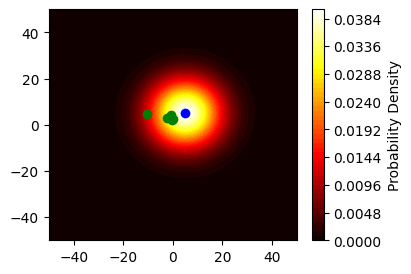

Starting Run number 15
Swarm is currently at [[-3.29655722e-01  2.22356795e+00  3.50000000e+01]
 [-2.53491948e+00  2.81501143e+00  3.50000000e+01]
 [-1.05006857e+01  4.58720888e+00  3.50000000e+01]
 [-2.79379914e-02  2.68806614e+00  3.50000000e+01]
 [-6.96923670e-01  4.14419475e+00  3.50000000e+01]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.792139E+03 | -1.842950E+03
     2 |       20 | -1.821934E+03 | -1.865363E+03
Best Solution: 
 [[-1.2956875   1.08728549]
 [ 1.2352954  -0.65007557]
 [-0.6198202   1.22517159]
 [-1.41848636  1.21604088]
 [ 0.13694498  0.40281608]]
Sending swarm to 
 [[ -1.62534322   3.31085343  35.        ]
 [ -1.29962408   2.16493586  35.        ]
 [-11.12050585   5.81238047  35.        ]
 [ -1.44642435   3.90410702  35.        ]
 [ -0.55997869   4.54701083  35.        ]]


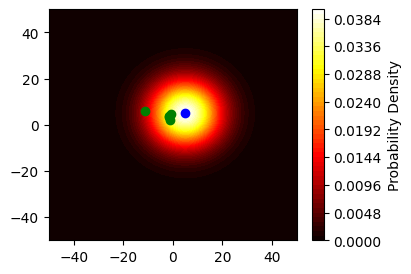

Starting Run number 16
Swarm is currently at [[ -1.62534322   3.31085343  35.        ]
 [ -1.29962408   2.16493586  35.        ]
 [-11.12050585   5.81238047  35.        ]
 [ -1.44642435   3.90410702  35.        ]
 [ -0.55997869   4.54701083  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.706624E+03 | -1.822799E+03
     2 |       20 | -1.750087E+03 | -1.855617E+03
Best Solution: 
 [[-0.55642527  0.34445595]
 [-0.21599332  1.74677153]
 [-0.23685846 -1.54793973]
 [ 1.88396659 -1.24222941]
 [-1.14378105 -1.06885021]]
Sending swarm to 
 [[ -2.18176849   3.65530939  35.        ]
 [ -1.51561741   3.91170739  35.        ]
 [-11.35736432   4.26444074  35.        ]
 [  0.43754224   2.66187761  35.        ]
 [ -1.70375974   3.47816062  35.        ]]


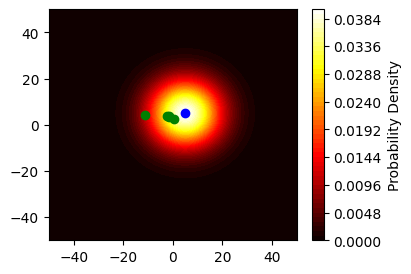

Starting Run number 17
Swarm is currently at [[ -2.18176849   3.65530939  35.        ]
 [ -1.51561741   3.91170739  35.        ]
 [-11.35736432   4.26444074  35.        ]
 [  0.43754224   2.66187761  35.        ]
 [ -1.70375974   3.47816062  35.        ]]
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -1.673021E+03 | -1.772591E+03


KeyboardInterrupt: 

In [19]:
finished=False
#Drone waypoints got from -25 to 25, Array from 0 to 50
#waypoints=np.array([[-5,0,35.],[-2,0,35.],[ 0,0,35.],[ 2,0,35.],[5,15,35.]])
#swarm.waypoints(ids,waypoints)

visibility_grid= "Null"
runNumber=0

#print(f"Starting with waypoints: \n {waypoints}")

sigma=10

while not finished:
    #wait until all drones received
    if swarm.received_frames[ids[-1]]:
        print(f"Starting Run number {runNumber}")
        print(f"Swarm is currently at {problem.waypoints}")
        runNumber+=1
        
        #get best solution
        res = minimize(problem, algorithm, termination, seed=1, verbose=True)
        _x= np.array(res.X)*4-2
        best_solution = _x.reshape(-1, 2)
        #best_solution = res.X.reshape(-1, 2)
        print(f"Best Solution: \n {best_solution}")
        #update waypoints
        waypoints = waypoints + np.pad(best_solution,((0, 0), (0, 1)),mode='constant',constant_values=0)
        swarm.waypoints(ids,waypoints)
        print(f"Sending swarm to \n {waypoints}")
        #update probability_grid and waypoints
        problem.waypoints = waypoints
        sigma+=1
        problem.prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)
        
        
        
        plt.figure(figsize=(4, 3))
        plt.contourf(x, y, prob_density, levels=50, cmap='hot')
        plt.colorbar(label='Probability Density')
        plt.scatter(Last_Known_Position[0],Last_Known_Position[1], color='blue', label='Last Known Position')
        plt.scatter(waypoints[:, 0],waypoints[:, 1], color='green', label='Drones')
        plt.show()
